### CDMI: Causal Discovery in Multivariate Timeseries

##### Notebook written by Wasim Ahmad <br> Computer Vision Group (CVG) <br> Friedrich Schiller University (FSU) Jena, Germany <br> Last updated on: April 19, 2024


The purpose of this notebook is to provide a simple usage example of the `CDMI` for generating causal graph for mulativariate time series. Higher-dimensional time series may require additional computational time or the availaibility of a graphical processing unit.

In [1]:
%load_ext autoreload
%autoreload 2

#### Load Dependencies

In [3]:
import pickle
import time
import pathlib
import parameters
import numpy as np
import mxnet as mx
import pandas as pd
import functions as func
import dataloader as datasets
import matplotlib.pyplot as plt
from knockoffs import Knockoffs
from regimes import get_regimes
from deepcause import deepCause
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput


In [ ]:
np.random.seed(1)
mx.random.seed(2)

#### Load Model Parameters

The parameters for model archicture varies from application to application depends on data dimensionality mainly

In [ ]:
start_time = time.time()
print(f'Time now: {start_time}')
# Parameters
pars = parameters.get_rivernet_params()
freq = pars.get("freq")
epochs = pars.get("epochs")
win_size = pars.get("win_size")
slidingwin_size = pars.get("slidingwin_size")
training_length = pars.get("train_len")
prediction_length = pars.get("pred_len")
num_samples = pars.get("num_samples")
num_layers = pars.get("num_layers")
num_cells = pars.get("num_cells")
dropout_rate = pars.get("dropout_rate")
batch_size = pars.get("batch_size")
plot_path = pars.get("plot_path")
model_name = pars.get("model_name") + '2'

Time now: 1714127535.7090595


#### Load Dataset

In [ ]:
df = datasets.load_river_network()
# df = df.iloc[:, 0:3]
# df.plot(figsize=(9, 4), linewidth=0.66, use_index=True)
# plt.show()
# func.corr_heatmap(df)
df.head()

,568102,568121,568133,568160,568350
2019-09-01 00:00:00,0.13,0.196,0.524,1.39,0.199
2019-09-01 00:15:00,0.13,0.196,0.524,1.39,0.199
2019-09-01 00:30:00,0.13,0.196,0.524,1.39,0.199
2019-09-01 00:45:00,0.13,0.196,0.438,1.39,0.199
2019-09-01 01:00:00,0.13,0.196,0.524,1.39,0.199


#### Generate Training Dataset

In [ ]:
original_data = []
dim, columns = len(df.columns), df.columns
for col in df:
    original_data.append(df[col])

original_data = np.array(original_data)
# training set
train_ds = ListDataset(
    [
        {'start': "01/03/2015 00:00:00",
         'target': original_data[:, 0: training_length].tolist()
         }
    ],
    freq=freq,
    one_dim_target=False
)

#### Create DeepAR Estimator

In [ ]:
# create estimator
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length,
    freq=freq,
    num_layers=num_layers,
    num_cells=num_cells,
    dropout_rate=dropout_rate,
    trainer=Trainer(
        ctx="cpu",
        epochs=epochs,
        hybridize=False,
        learning_rate=1E-4,
        batch_size=32
    ),
    distr_output=MultivariateGaussianOutput(dim=dim)
)

### Load/Train Model

In [ ]:
path = pars.get('model_path')
model_path = pathlib.Path(path + model_name)
# model_path = "../models/trained_model_georegime_cli9.sav"
# model_path = "../models/trained_model_syn22Sep.sav"
# model_path = "../models/trained_model_river16Jun.sav"

filename = pathlib.Path(model_path)
print(f'Model: {filename}')
if not filename.exists():
    print("Training forecasting model....")
    predictor = estimator.train(train_ds)
    # save the model to disk
    pickle.dump(predictor, open(filename, 'wb'))

Model: /home/ahmad/Projects/deepCausality/models/trained_model_rivernet5.sav2


#### Generate Knockoffs

In [ ]:
data_actual = np.array(original_data[:, :]).transpose()
n = len(original_data[:, 0])
obj = Knockoffs()
params = {"length": n, "dim": dim, "col": columns}
knockoffs = obj.GenKnockoffs(data_actual, params)

#### Esimate Causal Links

In [ ]:
# Function for estimating causal impact among variables
causal_matrix, predicted_graph, end_time = deepCause(original_data, knockoffs, model_path, params)

-------------*****-----------------------*****-------------
Causal Link: 568102 --------------> 568102
-------------*****-----------------------*****-------------
Intervention: In-dist
Test statistic: 0.15, p-value: 0, KLD: 0.01
Null hypothesis is rejected
Intervention: Out-dist
Test statistic: 1.0, p-value: 0, KLD: -3.01
Null hypothesis is rejected
Intervention: Mean
Test statistic: 0.15, p-value: 0, KLD: 0.02
Null hypothesis is rejected
Intervention: Uniform
Test statistic: 1.0, p-value: 0, KLD: -0.53
Null hypothesis is rejected
-------------*****-----------------------*****-------------
Causal Link: 568102 --------------> 568121
-------------*****-----------------------*****-------------
Intervention: In-dist
Test statistic: 0.1, p-value: 1.0, KLD: -0.0
Fail to reject null hypothesis
Intervention: Out-dist
Test statistic: 0.4, p-value: 0.08, KLD: 1.38
Fail to reject null hypothesis
Intervention: Mean
Test statistic: 0.15, p-value: 0.98, KLD: -0.26
Fail to reject null hypothesis
Inte

#### Generate Causal Graph

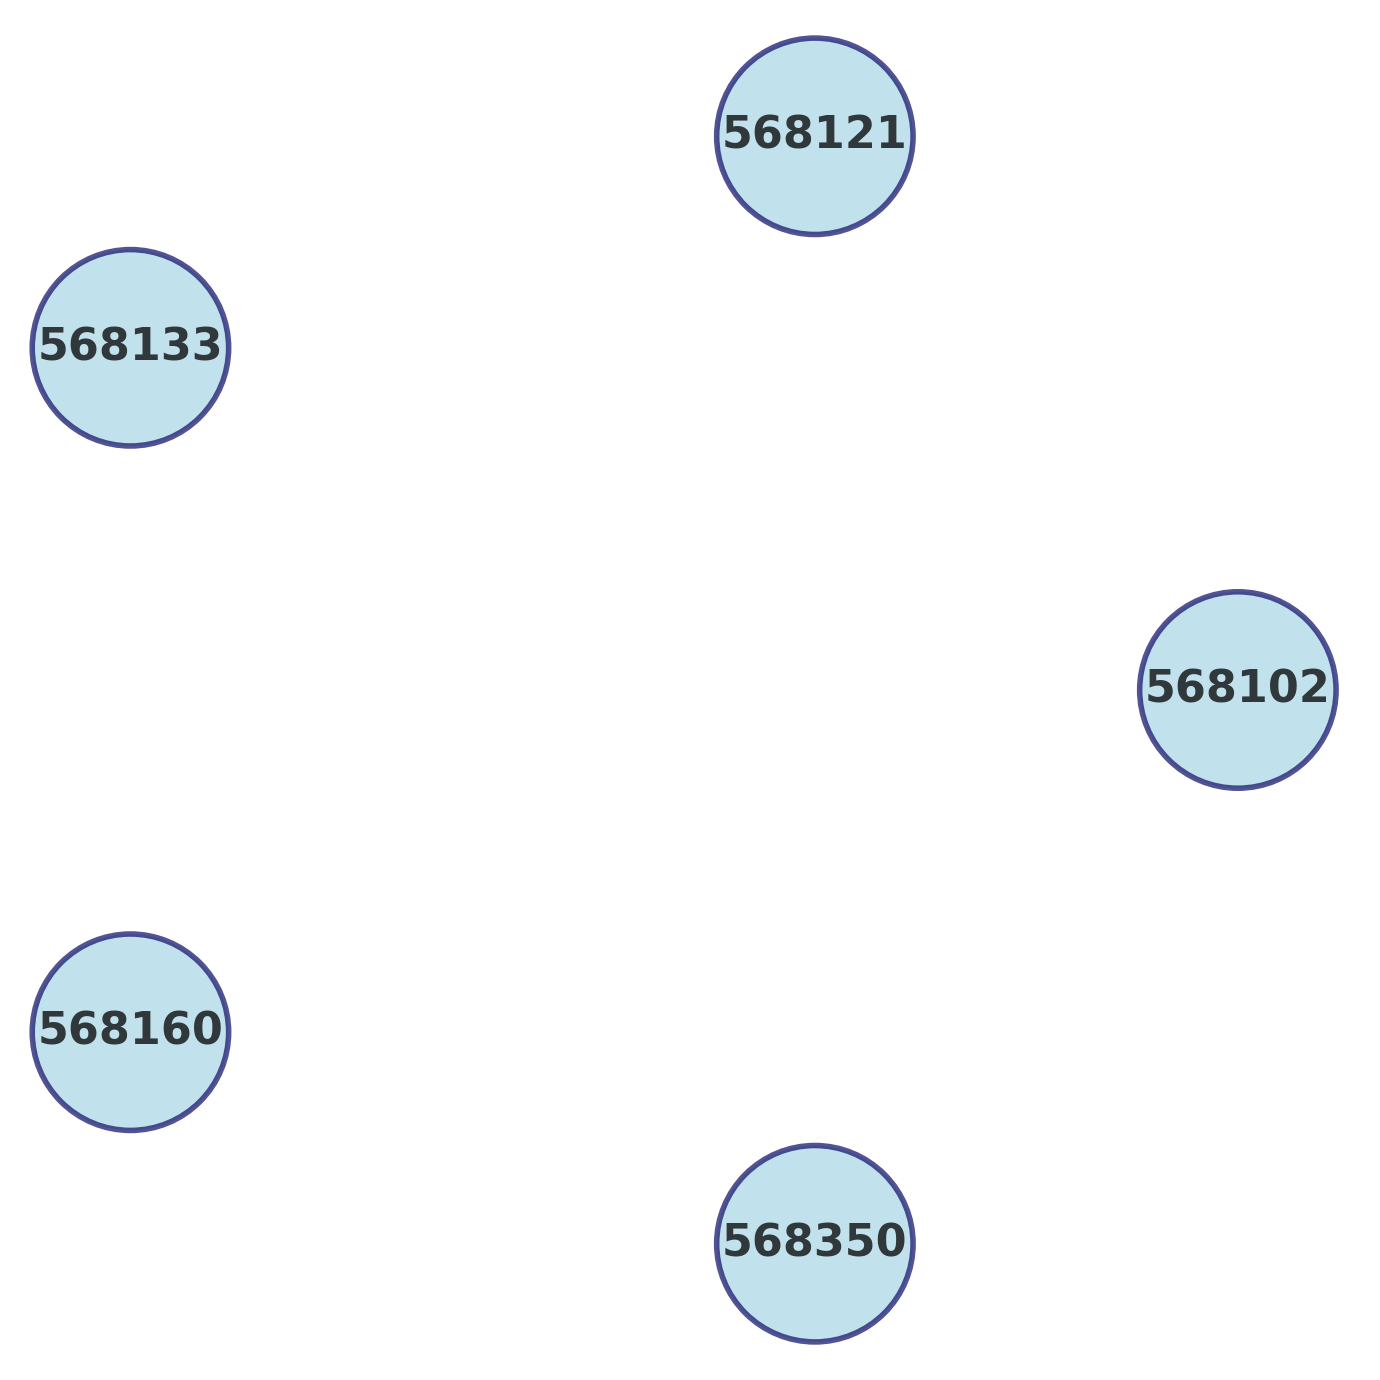

In [ ]:
func.plot_causal_graph(causal_matrix, columns, model_name)

#### Evaluate CDMI Performance

In [ ]:
intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']
actual_graph = pars.get("true_graph")
func.evaluate(actual_graph, predicted_graph, intervention_methods)

Called from Fun(c)!
---------***-----------***----------***----------
Intervention: In-dist
TP: 5, TN: 16, FP: 0, FN: 4
Precision: 1.0
Recall: 0.5555555555555556
Accuracy: 0.84
F-score: 0.71
---------***-----------***----------***----------
---------***-----------***----------***----------
Intervention: Out-dist
TP: 7, TN: 8, FP: 8, FN: 2
Precision: 0.4666666666666667
Recall: 0.7777777777777778
Accuracy: 0.6
F-score: 0.58
---------***-----------***----------***----------
---------***-----------***----------***----------
Intervention: Mean
TP: 6, TN: 13, FP: 3, FN: 3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
Accuracy: 0.76
F-score: 0.67
---------***-----------***----------***----------
---------***-----------***----------***----------
Intervention: Uniform
TP: 7, TN: 12, FP: 4, FN: 2
Precision: 0.6363636363636364
Recall: 0.7777777777777778
Accuracy: 0.76
F-score: 0.7
---------***-----------***----------***----------


#### Computation Time

In [ ]:
# Calculate difference
elapsed_time = end_time - start_time
# Print elapsed time
print("Computation time: ", round(elapsed_time/60), "mins")

Computation time: 22 mins
